In [1]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.6 MB/s eta 0:00:00a 0:00:010m


In [13]:
import csv
import torch
from datasets import Dataset
import transformers
from transformers import (
  AdamW,
  BertConfig,
  BertModel,
  BertTokenizer,
  DistilBertTokenizer,
  DistilBertModel,
  DistilBertForSequenceClassification,
  BertForSequenceClassification)
from torch.utils.data import DataLoader
import torch.nn as nn
import os
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

from IPython.display import display, HTML
import matplotlib as mpl
from matplotlib.colors import Normalize, rgb2hex
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
finegrained_sentiments_dict = {
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"]
}

In [4]:
!ls ../

input  lib  working


In [5]:
DATA_DIR = "../input/emotionclss/"
train = {"input": [], "labels": []}
dev = {"input": [], "labels": []}
test = {"input": [], "labels": []}

with open(DATA_DIR + "train.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t") 
    for line in tsv_file:
        train["input"].append(line[0])
        labels = line[1].split(",")
        one_hot = [0 for i in range(28)]
        for label in labels:
            one_hot[int(label)] = 1
        train["labels"].append(one_hot)

with open(DATA_DIR + "dev.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t") 
    for line in tsv_file:
        dev["input"].append(line[0])
        labels = line[1].split(",")
        one_hot = [0 for i in range(28)]
        for label in labels:
            one_hot[int(label)] = 1
        dev["labels"].append(one_hot)

with open(DATA_DIR + "test.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t") 
    for line in tsv_file:
        test["input"].append(line[0])
        labels = line[1].split(",")
        one_hot = [0 for i in range(28)]
        for label in labels:
            one_hot[int(label)] = 1
        test["labels"].append(one_hot)
        
print("Number of train examples are {}".format(len(train["input"])))
print("Number of dev examples are {}".format(len(dev["input"])))
print("Number of test examples are {}".format(len(test["input"])))

Number of train examples are 43410
Number of dev examples are 5426
Number of test examples are 5427


In [6]:
# Creating higgingface datasets
train_dataset = Dataset.from_dict(train)
dev_dataset = Dataset.from_dict(dev)
test_dataset = Dataset.from_dict(test)

print(train_dataset)

Dataset({
    features: ['input', 'labels'],
    num_rows: 43410
})


In [7]:
class LoadData(torch.utils.data.Dataset):
    """
    Using this since dataloader expects map-style dataset objects
    
    """
    
    def __init__(
        self, dataset, tokenizer, source_length):
        """
        Initializes a Dataset class

        Args:
            dataset (Dataset object): Input Dataset
            tokenizer (Tokenizer object): Transformer tokenizer
            source_length (int): Max length of source text
        """
        
        self.tokenizer = tokenizer
        self.data = dataset
        self.source_length = source_length
        self.source_text = self.data["input"]
        self.target_labels = self.data["labels"]

    def __len__(self):
        return len(self.target_labels)

    def __getitem__(self, index):
        """
        return input ids, attention masks and target ids
        
        """
        source_text = str(self.source_text[index])
        target_label = self.target_labels[index]

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())

        source = self.tokenizer.__call__(
            [source_text],
            max_length=self.source_length,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        target = torch.tensor(target_label)

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target": target.squeeze().to(dtype=torch.long)
        }

In [8]:
#joeddav/distilbert-base-uncased-go-emotions-student
parameters = {"model": "bhadresh-savani/bert-base-go-emotion",  # model_type: t5-base/t5-large
    "train_bs": 8,  # training batch size
    "val_bs": 10,  # validation batch size
    "test_bs": 15,
    "epochs": 3,  # number of training epochs
    "lr": 6e-4,  # learning rate
    "wd": 0.0001,
    "max_source_length": 512,  # max length of source text
    "SEED": 42,
    "out_dir": "./",
    "hidden_size": 768,
    "num_classes": 28}

index_label = {0:"admiration", 1:"amusement", 2:"anger", 3:"annoyance", 4:"approval", 5:"caring", 6:"confusion",
            7:"curiosity", 8:"desire", 9:"disappointment", 10:"disapproval", 11:"disgust", 12:"embarrassment",
            13:"excitement", 14:"fear", 15:"gratitude", 16:"grief", 17:"joy", 18:"love", 19:"nervousness",
            20:"optimism", 21:"pride", 22:"realization", 23:"relief", 24:"remorse", 25:"sadness",
            26:"surprise", 27:"neutral"}
label_list = list(index_label.values())

In [10]:
def compute_metrics_allemotions(outputs, labels, label_list_, index_label):
    predictions = []
    
    for output in outputs:
        output = [int(out > 0.32) for out in output]
        predictions.append(output)
    print("1st prediction", predictions[0])
    
    confusion_matrix = {}
    matrix = [list(np.zeros(28)) for _ in range(28)]
    precisions, recalls, fscores = {}, {}, {}
    for label in label_list_:
        confusion_matrix[label] = {"TP":0, "FP": 0, "FN": 0}
        precisions[label], recalls[label], fscores[label] = 0, 0, 0
    
    for i, prediction in enumerate(predictions):
        gt = labels[i]
        classes = [i for i in range(28) if gt[i] == 1]
        for j, out in enumerate(gt):
            pred = prediction[j]
            for class_ in classes:
                matrix[class_][j] += pred
            if out == 0 and pred == 0: continue
            elif out == 0 and pred == 1:
                # FP found
                confusion_matrix[index_label[j]]["FP"] += 1
            elif out == 1 and pred == 0:
                # FN found
                confusion_matrix[index_label[j]]["FN"] += 1
            elif out == 1 and pred == 1:
                # TP found
                confusion_matrix[index_label[j]]["TP"] += 1
    
    
    for label in label_list_:
        precisions[label] = confusion_matrix[label]["TP"]/(confusion_matrix[label]["TP"] + confusion_matrix[label]["FP"] + 1e-4)
        recalls[label] = confusion_matrix[label]["TP"]/(confusion_matrix[label]["TP"] + confusion_matrix[label]["FN"] + 1e-4)
        fscores[label] = 2*precisions[label]*recalls[label]/(precisions[label]+recalls[label] + 1e-4)
    
    return precisions, recalls, fscores, matrix

def compute_test_outputs(model, test_dataloader, tokenizer, device, label_list, index_label):
    predictions = []
    labels = []
    
    with torch.no_grad():
        steps = 0
        for test_batch in test_dataloader:
            y = test_batch['target'].to(device, dtype = torch.float32)
            ids = test_batch['source_ids'].to(device, dtype = torch.long)
            mask = test_batch['source_mask'].to(device, dtype = torch.long)

            output = model(
                input_ids=ids,
                attention_mask=mask,
            )
            
            output = output["logits"]
            output = torch.sigmoid(output)
            
            predictions.extend(output.detach().cpu().numpy())
            labels.extend(y.detach().cpu().numpy())
#             if steps == 5: break
    
    return predictions, labels

In [11]:
cuda =  torch.cuda.is_available()
device = torch.device("cuda") if cuda else torch.device("cpu")

tokenizer = DistilBertTokenizer.from_pretrained(parameters["model"])
model = BertForSequenceClassification.from_pretrained(parameters["model"])
model = model.to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

## Computing test data Fscores

In [12]:
test_obj = LoadData(
        test_dataset,
        tokenizer,
        parameters["max_source_length"]
    )
test_loader = DataLoader(test_obj, shuffle=True, batch_size=parameters["test_bs"])
predictions, labels = compute_test_outputs(model, test_loader, tokenizer, device, label_list, index_label)

In [14]:
precisions, recalls, fscores, conf_matrix = compute_metrics_allemotions(predictions, labels, label_list, index_label)
print("Precision, Recall and Fscores for all labels are ")

precision, recall, fscore = 0, 0, 0
for label in label_list:
    precision += precisions[label]
    recall += recalls[label]
    fscore += fscores[label]
    print("Emotion {}: precision: {}, recall: {}, fscore: {}".format(label, precisions[label], 
                                                                     recalls[label], fscores[label]))

print("Macro precision: {}, Macro recall: {}, Macro fscore: {}".format(precision/28, recall/28, fscore/28))

1st prediction [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Precision, Recall and Fscores for all labels are 
Emotion admiration: precision: 0.7300612003964826, recall: 0.7083331927910332, fscore: 0.7189831026922668
Emotion amusement: precision: 0.7641507030972632, recall: 0.9204541967976528, fscore: 0.8350016928135315
Emotion anger: precision: 0.5902773678629389, recall: 0.42929271247842804, fscore: 0.49702698402148593
Emotion annoyance: precision: 0.5662643779947253, recall: 0.14687495410157686, fscore: 0.23321780161193786
Emotion approval: precision: 0.583332928241022, recall: 0.23931617113499398, fscore: 0.3393525510741509
Emotion caring: precision: 0.5396816830449476, recall: 0.25185166529506275, fscore: 0.343390613569084
Emotion confusion: precision: 0.6206885850196809, recall: 0.23529396386015433, fscore: 0.34119204434929035
Emotion curiosity: precision: 0.5342463923813725, recall: 0.5492955812339503, fscore: 0.5416164928462633
Emotion des

<AxesSubplot:>

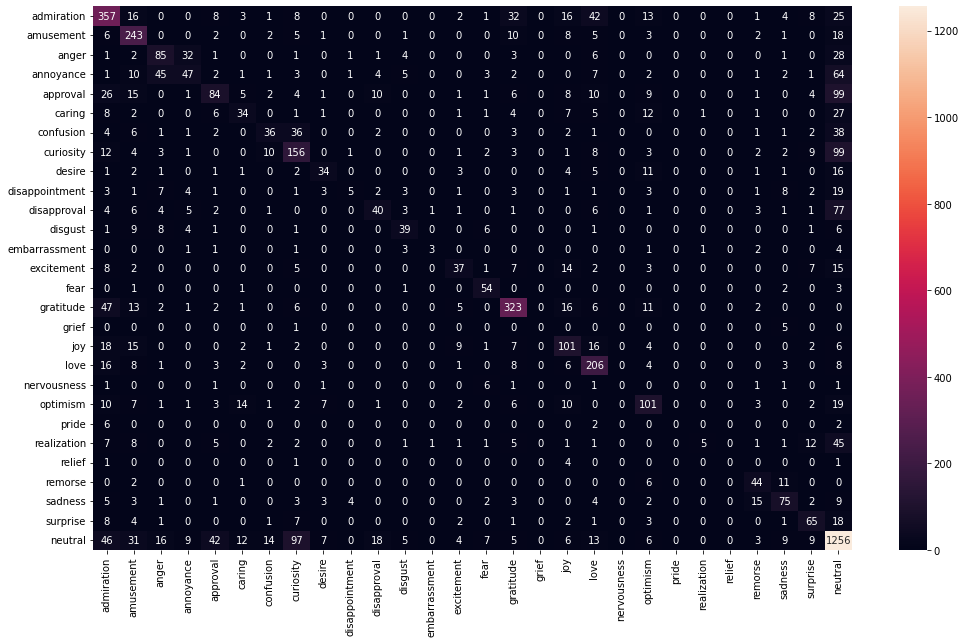

In [21]:
# plotting the confusion matrix
df_cm = pd.DataFrame(conf_matrix, index = [label for label in label_list],
                  columns = [label for label in label_list])
plt.figure(figsize = (17,10))
sn.heatmap(df_cm, annot=True, fmt='g')

In [11]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator at the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the word sequence

In [12]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * (len(input_ids)-2) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(input_ids)

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def predict(inputs, attention_mask=None):
    output = model(inputs, attention_mask=attention_mask, )
    output = output["logits"]
    output = torch.sigmoid(output)
    return output

def forward_func(inputs, i, device, attention_mask=None):
    pred = predict(inputs,
                   attention_mask=attention_mask)
    #return pred.max(1).values
    pred = torch.index_select(pred, 1, torch.tensor([i], device=device))
    return pred

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [13]:
# preparing data
data = []
for i,text in enumerate(test_dataset["input"][0:100]):
    out = test_dataset["labels"][i]
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device)
    attention_mask = construct_attention_mask(input_ids)
    out = torch.tensor([out], device=device)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    #print(len(out[0]), len(input_ids[0]), len(ref_input_ids[0]), len(attention_mask[0]))
    data.append((out, input_ids, ref_input_ids, attention_mask, all_tokens))

In [38]:
def colorize(attrs, cmap='PiYG'):

    cmap_bound = max([abs(attr) for attr in attrs])

    norm = Normalize(vmin=-cmap_bound, vmax=cmap_bound)

    cmap = mpl.cm.get_cmap(cmap)
    colors = list(map(lambda x: rgb2hex(cmap(norm(x))), attrs))

    return colors

def  hlstr(string, color='white'):
    return f"<mark style=background-color:{color}>{string} </mark>"    
    
def explainability(data, limit):
    lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)  # embeddings is the first layer
    attributions = []
    predictions = []
    for j,sample in enumerate(data[0:limit]):
        pred = predict(sample[1], attention_mask=sample[3])

        classes = []
        for i in range(0,28):
            attribution, delta = lig.attribute(inputs=sample[1],
                                          baselines=sample[2],
                                          additional_forward_args=(i, device, sample[3]),
                                          return_convergence_delta=True)
            attribution = summarize_attributions(attribution).detach().cpu().numpy()
            attribution = [(attr,k) for k,attr in enumerate(attribution)]
            attribution.sort(key=(lambda x: x[0]), reverse=True)
            classes.append(attribution)
        attributions.append(classes)
        predictions.append(pred)
    return attributions, predictions

def color(word_scores, words):
    colors = colorize(word_scores)
    colored_input = []
    display(HTML("".join(list(map(hlstr, words, colors)))))

In [16]:
print("Predicted label is:", index_label[np.argmax(predictions[3][0].detach().cpu().numpy())], np.argmax(predictions[3][0].detach().cpu().numpy()))
print("printing more valuable 3 words for each class:")
for i in range(28):
    print("Now we have class {}!!!!".format(index_label[i]))
    words = []
    for k in range(5):
        words.append(data[3][-1][attributions[3][i][k][1]])
    print(tuple(words))

Predicted label is: gratitude 15
printing more valuable 3 words for each class:
Now we have class admiration!!!!
(',', "'", '!', 'thank', 'today')
Now we have class amusement!!!!
('i', '!', 'me', "'", ',')
Now we have class anger!!!!
('t', 'me', 'didn', 'teaching', '!')
Now we have class annoyance!!!!
('t', 'didn', 'me', "'", '!')
Now we have class approval!!!!
("'", 'know', 'you', 'today', ',')
Now we have class caring!!!!
('you', 'thank', "'", ',', 'for')
Now we have class confusion!!!!
('know', 'didn', 't', 'something', 'i')
Now we have class curiosity!!!!
('know', 'didn', 'something', 'me', 'for')
Now we have class desire!!!!
('i', 'something', 'for', 'you', 'today')
Now we have class disappointment!!!!
('t', 'didn', 'me', 'teaching', 'for')
Now we have class disapproval!!!!
('t', "'", 'didn', 'teaching', '[CLS]')
Now we have class disgust!!!!
('t', 'didn', 'me', "'", 'teaching')
Now we have class embarrassment!!!!
('didn', 'me', 'i', 't', 'teaching')
Now we have class excitement!!

In [18]:
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(pred),
                        torch.argmax(pred),
                        torch.argmax(pred),
                        str(14),
                        attributions_start_sum.sum(),
                        all_tokens,
                        delta_start)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

 Visualizations For Start Position 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
20,20 (0.42),14,1.40,"[CLS] kings fan here , good luck to you guys ! will be an interesting game to watch ! [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
20,20 (0.42),14,1.40,"[CLS] kings fan here , good luck to you guys ! will be an interesting game to watch ! [SEP]"


## Analyzing Grief

In [17]:
grief = {"input":[], "labels":[]}
for i,text in enumerate(test_dataset["input"]):
    out = test_dataset["labels"][i]
    if out[16] == 1:
        grief["input"].append(text)
        grief["labels"].append(out)

print(len(grief["input"]))

6


In [18]:
data_grief = []
for i,text in enumerate(grief["input"]):
    out = grief["labels"][i]
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device)
    attention_mask = construct_attention_mask(input_ids)
    out = torch.tensor([out], device=device)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    data_grief.append((out, input_ids, ref_input_ids, attention_mask, all_tokens))

In [33]:
attributions, predictions = explainability(data_grief, 10)
predictions = [pred.detach().cpu().numpy()[0] > 0.32 for pred in predictions]

In [37]:
for k, pred in enumerate(predictions):
    classes = [index_label[index] for index,i in enumerate(pred) if i]
    print("predicted classes are {}".format(classes))
    print("Input text is {}".format(grief["input"][k]))
    print("Important words are:")
    classes = [index for index,i in enumerate(pred) if i]
    words = []
    for index in classes:
        for m in range(6):
            words.append(data_grief[k][-1][attributions[k][index][m][1]])
    print(tuple(words))

predicted classes are ['curiosity']
Input text is [NAME] death is just so..... senseless. Why? WHY??? The based gods have forsaken us
Important words are:
('?', '?', '?', '?', 'why', 'name')
predicted classes are ['sadness']
Input text is Rip the guy from psych
Important words are:
('rip', '##ych', 'the', 'guy', '[CLS]', '[SEP]')
predicted classes are ['sadness']
Input text is The only death that made me feel any emotion. And it wasn’t even the death itself.
Important words are:
('death', 'death', 'feel', 'me', 'made', 'even')
predicted classes are ['sadness']
Input text is My condolences.
Important words are:
('##lence', 'condo', 'my', '##s', '[CLS]', '[SEP]')
predicted classes are ['sadness']
Input text is Oh my gosh. This woman who died also had a son who died. Holy tragedy
Important words are:
('died', 'died', 'son', 'go', 'my', 'woman')
predicted classes are ['sadness']
Input text is You'll miss a begging old man asking for a spare coin. RIP
Important words are:
('rip', 'miss', 'o

## Analyzing pride

In [38]:
pride = {"input":[], "labels":[]}
for i,text in enumerate(test_dataset["input"]):
    out = test_dataset["labels"][i]
    if out[21] == 1:
        pride["input"].append(text)
        pride["labels"].append(out)

print(len(pride["input"]))

16


In [39]:
data_pride = []
for i,text in enumerate(pride["input"]):
    out = pride["labels"][i]
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device)
    attention_mask = construct_attention_mask(input_ids)
    out = torch.tensor([out], device=device)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    data_pride.append((out, input_ids, ref_input_ids, attention_mask, all_tokens))

In [40]:
attributions, predictions = explainability(data_pride, 16)
predictions = [pred.detach().cpu().numpy()[0] > 0.32 for pred in predictions]

In [42]:
for k, pred in enumerate(predictions):
    classes = [index_label[index] for index,i in enumerate(pred) if i]
    print("predicted classes are {}".format(classes))
    print("Input text is {}".format(pride["input"][k]))
    print("Important words are:")
    classes = [index for index,i in enumerate(pred) if i]
    words = []
    for index in classes:
        for m in range(6):
            words.append(data_pride[k][-1][attributions[k][index][m][1]])
    print(tuple(words))

predicted classes are ['neutral']
Input text is I only eat cronuts cuz I'm sophisticated!
Important words are:
('sophisticated', 'only', '##z', 'i', 'm', '##uts')
predicted classes are ['admiration']
Input text is This internet stranger is also super proud of you! Way to go!!!
Important words are:
('proud', 'super', 'this', 'you', 'stranger', 'go')
predicted classes are []
Input text is That’s better:-) now go get em tiger
Important words are:
()
predicted classes are ['admiration']
Input text is My jersey has the great number 10 on it!!
Important words are:
('great', 'my', 'it', '!', 'the', '10')
predicted classes are []
Input text is And I taught my room was dirty and that I was not taking care of my self. Good job op
Important words are:
()
predicted classes are ['admiration']
Input text is I am proud of you random internet stranger, you peopled good today.
Important words are:
('good', 'proud', 'i', 'stranger', 'internet', '##d')
predicted classes are []
Input text is That's nothin

## Analyze Relief

In [14]:
relief = {"input":[], "labels":[]}
for i,text in enumerate(test_dataset["input"]):
    out = test_dataset["labels"][i]
    if out[23] == 1:
        relief["input"].append(text)
        relief["labels"].append(out)

print(len(relief["input"]))

11


In [15]:
data_relief = []
for i,text in enumerate(relief["input"]):
    out = relief["labels"][i]
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device)
    attention_mask = construct_attention_mask(input_ids)
    out = torch.tensor([out], device=device)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    data_relief.append((out, input_ids, ref_input_ids, attention_mask, all_tokens))

In [16]:
attributions, predictions = explainability(data_relief, 16)
predictions = [pred.detach().cpu().numpy()[0] > 0.32 for pred in predictions]

In [20]:
len(attributions[1][0])

17

In [ ]:
#coloring important words
attribution_colors = []
for k, pred in enumerate(predictions):
    classes = [index_label[index] for index,i in enumerate(pred) if i]
    print("predicted classes are {}".format(classes))
    print("Input text is {}".format(relief["input"][k]))
    print("Colored importance is:")
    classes = [index for index,i in enumerate(pred) if i]
    words = []
    for index in classes:
        for m in range(6):
            words.append(data_relief[k][-1][attributions[k][index][m][1]])
    print(tuple(words))

In [51]:
for k in [8]:
    pred = predictions[k]
    classes = [index_label[index] for index,i in enumerate(pred) if i]
    print("predicted classes are {}".format(classes))
    print("Input text is {}".format(relief["input"][k]))
    print("Important words are:")
    classes = [index for index,i in enumerate(pred) if i]
    for index in classes:
        class_attr = attributions[k][index]
        word_scores = [0 for _ in range(len(class_attr))]
        words = ["" for _ in range(len(class_attr))]
        for m in range(len(class_attr)):
            word_scores[class_attr[m][1]] = class_attr[m][0]
            words[class_attr[m][1]] = data_relief[k][-1][class_attr[m][1]]
            
        print(" ".join(words[1:-1]))
        color(word_scores[1:-1], words[1:-1])

predicted classes are ['admiration']
Input text is This is really helpful to point out!!
Important words are:
this is really helpful to point out ! !


## Clubbing dataset in sentiment classes

In [16]:
sentiment_grouped = {
    "positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
    "negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
    "ambiguous": ["realization", "surprise", "curiosity", "confusion"],
    "neutral": ["neutral"]
}
index_label_sentiment = {0: "positive", 1: "negative", 2: "ambiguous", 3: "neutral"}
label_index_sentiment = {"positive": 0, "negative": 1, "ambiguous": 2, "neutral": 3}
label_list_sentiment = ["positive", "negative", "ambiguous", "neutral"]

In [17]:
def get_sentiment(label, sentiment_grouped, label_index_sentiment):
    for key, value in sentiment_grouped.items():
        if label in value:
            return label_index_sentiment[key]
    return label_index_sentiment["neutral"]

# changing labels of test set
test_sentiment = {"input":[], "labels":[]}
for i,text in enumerate(test_dataset["input"]):
    output = test_dataset["labels"][i]
    new_out = [0 for _ in range(4)]
    for j, out in enumerate(output):
        if out == 1:
            sentiment = get_sentiment(index_label[j], sentiment_grouped, label_index_sentiment)
            new_out[sentiment] = 1
    
    test_sentiment["input"].append(text)
    test_sentiment["labels"].append(new_out)

In [18]:
from datasets import Dataset
test_sentiment_dataset = Dataset.from_dict(test_sentiment)

In [63]:
test_sent_obj = LoadData(
        test_sentiment_dataset,
        tokenizer,
        parameters["max_source_length"]
    )
test_loader = DataLoader(test_sent_obj, shuffle=True, batch_size=parameters["test_bs"])
predictions, labels = compute_test_outputs(model, test_loader, tokenizer, device, label_list_sentiment, index_label_sentiment)

In [64]:
predictions_sent = []
for i,pred in enumerate(predictions):
    new_out = [0 for _ in range(4)]
    for j, out in enumerate(pred):
        if out > 0.32:
            sentiment = get_sentiment(index_label[j], sentiment_grouped, label_index_sentiment)
            new_out[sentiment] = 1
    
    predictions_sent.append(new_out)

In [68]:
precisions, recalls, fscores = compute_metrics_allemotions(predictions_sent, labels, label_list_sentiment, index_label_sentiment)
print("Precision, Recall and Fscores for all labels are ")

precision, recall, fscore = 0, 0, 0
for label in label_list_sentiment:
    precision += precisions[label]
    recall += recalls[label]
    fscore += fscores[label]
    print("Emotion {}: precision: {}, recall: {}, fscore: {}".format(label, precisions[label], 
                                                                     recalls[label], fscores[label]))

print("Macro precision: {}, Macro recall: {}, Macro fscore: {}".format(precision/4, recall/4, fscore/4))

1st prediction [0, 1, 0, 0]
Precision, Recall and Fscores for all labels are 
Emotion positive: precision: 0.8766446887804447, recall: 0.7599809524723882, fscore: 0.8141050018001232
Emotion negative: precision: 0.8385415210865416, recall: 0.38272580168575265, fscore: 0.5255281845533213
Emotion ambiguous: precision: 0.6845636052430414, recall: 0.4519940248162445, fscore: 0.5444359866926374
Emotion neutral: precision: 0.7112117377569798, recall: 0.7028539058279851, fscore: 0.7069581276009392
Macro precision: 0.7777403882167517, Macro recall: 0.5743886712005927, Macro fscore: 0.6477568251617553


## Analysing admiration with Perturbations in Input

In [14]:
admiration = {"input":[], "labels":[]}
cnt = 0
for i,text in enumerate(test_dataset["input"]):
    out = test_dataset["labels"][i]
    if out[0] == 1:
        cnt += 1
        admiration["input"].append(text)
        admiration["labels"].append(out)
    if cnt == 30: break

print(len(admiration["input"]))

30


In [15]:
data_admiration = []
for i,text in enumerate(admiration["input"]):
    out = admiration["labels"][i]
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device)
    attention_mask = construct_attention_mask(input_ids)
    out = torch.tensor([out], device=device)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    data_admiration.append((out, input_ids, ref_input_ids, attention_mask, all_tokens))

In [18]:
attributions, predictions = explainability(data_admiration, 16)
predictions = [pred.detach().cpu().numpy()[0] > 0.32 for pred in predictions]

In [37]:
for k, pred in enumerate(predictions):
    classes = [index_label[index] for index,i in enumerate(pred) if i]
    print("predicted classes are {}".format(classes))
    print("Input text is {}".format(admiration["input"][k]))
    print("Important words are:")
    classes = [index for index,i in enumerate(pred) if i]
    words = []
    for index in classes:
        for m in range(6):
            words.append(data_admiration[k][-1][attributions[k][index][m][1]])
    print(tuple(words))

predicted classes are ['admiration']
Input text is It's wonderful because it's awful. At not with.
Important words are:
('wonderful', 'awful', 'it', 's', 's', 'with')
predicted classes are ['admiration', 'curiosity']
Input text is It's great that you're a recovering addict, that's cool. Have you ever tried DMT?
Important words are:
('great', 'cool', 'it', 's', 'that', 're', '?', "'", 'recovering', 'd', ',', 'tried')
predicted classes are ['love']
Input text is This guy is a little turd but I love him so dearly. I'll pass on your kisses :)
Important words are:
('love', 'i', 'i', '##rd', 'so', 'this')
predicted classes are ['amusement']
Input text is in what universe? lol the mr. blue sky cover is one of the best on the album imo.
Important words are:
('lo', '##l', 'universe', 'in', 'album', 'best')
predicted classes are ['admiration', 'amusement']
Input text is Lol looks delicious
Important words are:
('delicious', 'looks', '[CLS]', '[SEP]', '##l', 'lo', 'lo', '##l', 'looks', '[CLS]', '

In [26]:
# removing certain words and checking
# original text = Well done dude! Seriously :) But keep it up, don't lose this momentum.
texts = ["WSeriously :) But keep it up, don't lose this momentum."]
labels = [[0 for i in range(28)]]
labels[0][0] = 1
data_peturbe = []
for i,text in enumerate(texts):
    out = labels[i]
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device)
    attention_mask = construct_attention_mask(input_ids)
    out = torch.tensor([out], device=device)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    data_peturbe.append((out, input_ids, ref_input_ids, attention_mask, all_tokens))
attributions_peturbe, predictions_peturbe = explainability(data_peturbe, 16)
print(predictions_peturbe)
predictions_peturbe = [pred.detach().cpu().numpy()[0] > 0.32 for pred in predictions_peturbe]
for k, pred in enumerate(predictions_peturbe):
    classes = [index_label[index] for index,i in enumerate(pred) if i]
    print("predicted classes are {}".format(classes))
    print("Input text is {}".format(texts[k]))
    print("Important words are:")
    classes = [index for index,i in enumerate(pred) if i]
    words = []
    for index in classes:
        for m in range(6):
            words.append(data_peturbe[k][-1][attributions_peturbe[k][index][m][1]])
    print(tuple(words))

[tensor([[0.0357, 0.0025, 0.0170, 0.0703, 0.1754, 0.1414, 0.0047, 0.0032, 0.0090,
         0.0679, 0.0820, 0.0118, 0.0055, 0.0083, 0.0247, 0.0815, 0.0055, 0.0186,
         0.0014, 0.0253, 0.0699, 0.0221, 0.0770, 0.0766, 0.0062, 0.0204, 0.0081,
         0.1479]], device='cuda:0', grad_fn=<SigmoidBackward0>)]
predicted classes are []
Input text is Seriously :) But keep it up, don't lose this momentum.
Important words are:
()


In [21]:
data_admiration[0][-1]

['[CLS]',
 'it',
 "'",
 's',
 'wonderful',
 'because',
 'it',
 "'",
 's',
 'awful',
 '.',
 'at',
 'not',
 'with',
 '.',
 '[SEP]']